In [1]:
import numpy as np 
import pandas as pd 
import os
import glob
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import cv2, torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from tqdm import tqdm
import torch.nn as nn
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score
from sklearn.utils import resample
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import ConfusionMatrixDisplay
import seaborn as sns
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings("ignore")
import matplotlib.cm as colormap
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
import time
import torchvision.models as models
import copy

In [2]:
class dataset(Dataset):
    def __init__(self, images_dir, transform, device):
        self.images_dir = images_dir
        self.transform = transform
        self.device = device
        self.class_names = sorted(os.listdir(self.images_dir))
        self.image_paths = []
        self.labels = []
        for i, class_name in enumerate(self.class_names):
            class_path = os.path.join(self.images_dir, class_name)
            for image_name in os.listdir(class_path):
                image_path = os.path.join(class_path, image_name)
                self.image_paths.append(image_path)
                self.labels.append(i)
        self.device = device
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, index):
        image_path = self.image_paths[index]
        label = self.labels[index]
        image = cv2.imread(image_path)
        image = self.transform(image).to(self.device)
        label = torch.LongTensor([label]).to(self.device)
        return image, label

In [3]:
def plot_data_loader(data_loader, gridDims, class_names):
    fig, axes = plt.subplots(nrows=gridDims[0], ncols=gridDims[1], figsize=(5,5))
    dataiter = iter(data_loader)
    for i in range(gridDims[0]):
        for j in range(gridDims[1]):
            images, labels = next(dataiter)
            axes[i, j].imshow(np.transpose(images[0].cpu().numpy(), (1, 2, 0)))
            axes[i, j].set_title(class_names[labels[0]])
            axes[i, j].axis('off')
    plt.tight_layout()
    plt.show()

In [4]:
def train_model(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    for inputs, labels in tqdm(train_loader):
        labels = labels.reshape(-1)
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = running_corrects.double() / len(train_loader.dataset)
    return epoch_loss, epoch_acc

In [5]:
def val_model(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader):
            labels = labels.reshape(-1)
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
    epoch_loss = running_loss / len(test_loader.dataset)
    epoch_acc = running_corrects.double() / len(val_loader.dataset)
    return epoch_loss, epoch_acc

In [6]:
def test_model(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    all_preds = []
    all_labels = []
    all_probs = []
    all_labelsForProbs = []
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader):
            labels = labels.reshape(-1)
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            probs = torch.nn.functional.softmax(outputs, dim=1).cpu().numpy()
            all_probs.append(probs)
            all_labelsForProbs.append(labels.cpu().numpy())
            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            all_preds += preds.cpu().numpy().tolist()
            all_labels += labels.cpu().numpy().tolist()
    all_probs = np.concatenate(all_probs)
    all_labelsForProbs = np.concatenate(all_labelsForProbs)
    epoch_acc = running_corrects.double() / len(test_loader.dataset)
    epoch_classification_report = classification_report(all_labels, all_preds)
    print(f'Test Results:')
    print(f'Test Accuracy: {epoch_acc:.4f}')
    print(f'\n{epoch_classification_report}')
    cm = confusion_matrix(all_labels, all_preds)
    ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
                     xticklabels=test_data.class_names, yticklabels=test_data.class_names)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    n_classes = len(test_data.class_names)
    y_test = label_binarize(all_labelsForProbs, classes=range(n_classes))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], all_probs[:, i])
        roc_auc[i] = roc_auc_score(y_test[:, i], all_probs[:, i], average='macro')
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), all_probs.ravel())
    roc_auc["micro"] = roc_auc_score(y_test, all_probs, average="micro")
    plt.figure()
    lw = 2
    plt.plot(fpr["micro"], tpr["micro"], label=f'micro-average ROC (AUC = {roc_auc["micro"]:.2f})', linestyle=':', linewidth=4)
    label_names = test_data.class_names
    cmap = colormap.get_cmap('tab20',len(label_names))
    colors = [cmap(i) for i in range(len(label_names))]
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label=f'{test_data.class_names[i]} (AUC = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.show()

--------------------------------------------------------------------------------------------------------
FER2013
--------------------------------------------------------------------------------------------------------
train_images: 3208
val_images: 809
test_images: 1020


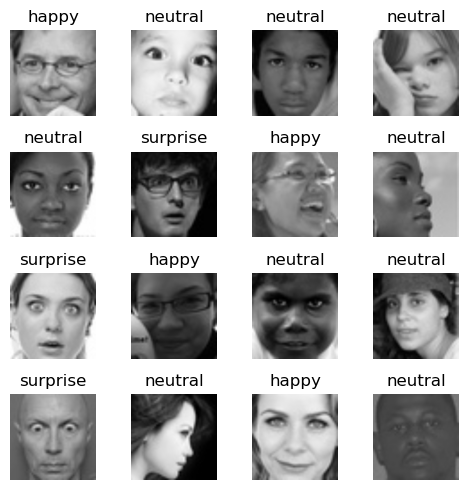

--------------------------------------------------------------------------------------------------------
resnet18_FER2013
--------------------------------------------------------------------------------------------------------


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Device: cuda
FLOPS: 990.436 billion


100%|██████████| 7/7 [00:04<00:00,  1.69it/s]


Epoch 1/25 | Train Loss: 0.6570 | Train Acc: 0.7425 | Val Loss: 0.6462 | Val Acc: 0.7379


100%|██████████| 7/7 [00:02<00:00,  3.21it/s]


Epoch 2/25 | Train Loss: 0.4312 | Train Acc: 0.8370 | Val Loss: 0.3902 | Val Acc: 0.8220


100%|██████████| 7/7 [00:02<00:00,  3.30it/s]


Epoch 3/25 | Train Loss: 0.3328 | Train Acc: 0.8744 | Val Loss: 0.3369 | Val Acc: 0.8307


100%|██████████| 7/7 [00:02<00:00,  3.29it/s]


Epoch 4/25 | Train Loss: 0.2890 | Train Acc: 0.8915 | Val Loss: 0.3415 | Val Acc: 0.8393


100%|██████████| 7/7 [00:02<00:00,  2.68it/s]


Epoch 5/25 | Train Loss: 0.2938 | Train Acc: 0.8900 | Val Loss: 0.3502 | Val Acc: 0.8591


100%|██████████| 7/7 [00:02<00:00,  3.28it/s]


Epoch 6/25 | Train Loss: 0.2162 | Train Acc: 0.9258 | Val Loss: 0.3736 | Val Acc: 0.8430


100%|██████████| 7/7 [00:02<00:00,  3.26it/s]


Epoch 7/25 | Train Loss: 0.1862 | Train Acc: 0.9311 | Val Loss: 0.4083 | Val Acc: 0.8443


100%|██████████| 7/7 [00:02<00:00,  3.18it/s]


Epoch 8/25 | Train Loss: 0.1893 | Train Acc: 0.9308 | Val Loss: 0.4497 | Val Acc: 0.8047


100%|██████████| 7/7 [00:02<00:00,  3.15it/s]


Epoch 9/25 | Train Loss: 0.3185 | Train Acc: 0.8862 | Val Loss: 0.4565 | Val Acc: 0.8059


100%|██████████| 7/7 [00:02<00:00,  3.15it/s]


Epoch 10/25 | Train Loss: 0.1624 | Train Acc: 0.9411 | Val Loss: 0.3120 | Val Acc: 0.8554


100%|██████████| 7/7 [00:02<00:00,  2.73it/s]


Epoch 11/25 | Train Loss: 0.1056 | Train Acc: 0.9645 | Val Loss: 0.4890 | Val Acc: 0.8208


100%|██████████| 7/7 [00:02<00:00,  3.08it/s]


Epoch 12/25 | Train Loss: 0.0827 | Train Acc: 0.9732 | Val Loss: 0.4402 | Val Acc: 0.8393
Early stopping at epoch 12
Average time per epoch: 16.61 seconds


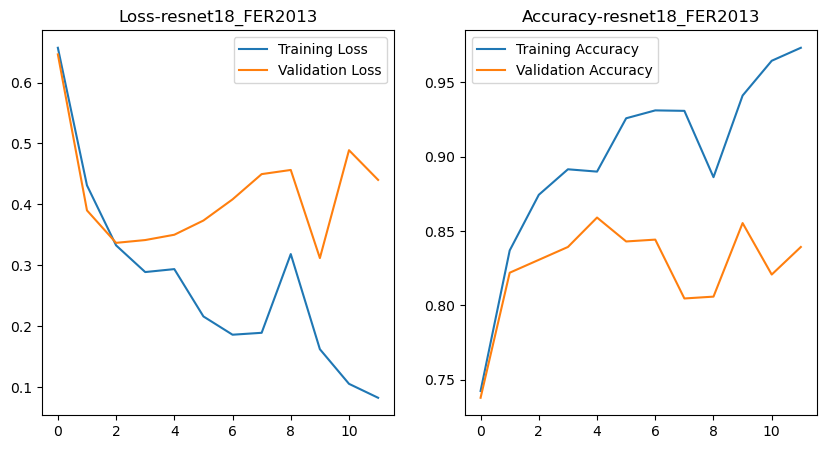

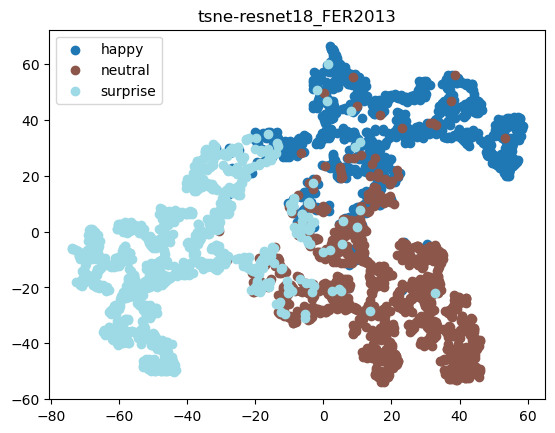

100%|██████████| 8/8 [00:04<00:00,  1.64it/s]

Test Results:
Test Accuracy: 0.8176

              precision    recall  f1-score   support

           0       0.85      0.77      0.81       340
           1       0.75      0.86      0.80       340
           2       0.86      0.82      0.84       340

    accuracy                           0.82      1020
   macro avg       0.82      0.82      0.82      1020
weighted avg       0.82      0.82      0.82      1020



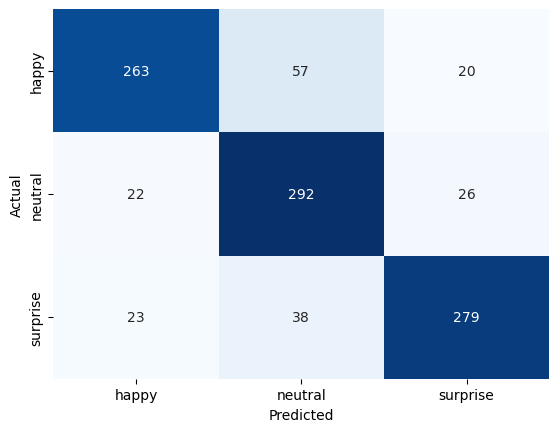

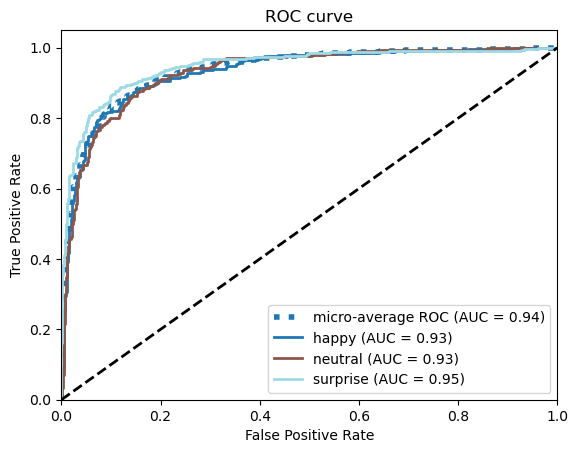

--------------------------------------------------------------------------------------------------------
Tiny
--------------------------------------------------------------------------------------------------------
train_images: 9620
val_images: 2470
test_images: 2990


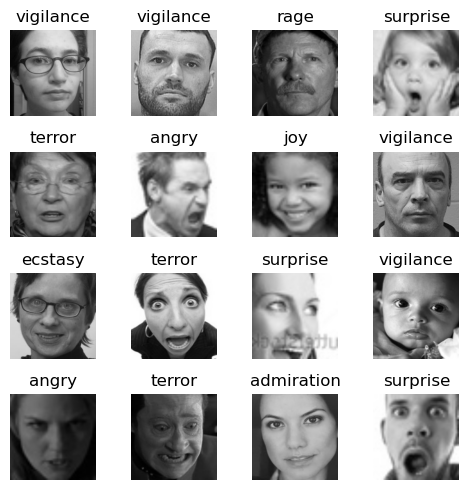

--------------------------------------------------------------------------------------------------------
resnet18_Tiny
--------------------------------------------------------------------------------------------------------
Device: cuda
FLOPS: 990.436 billion


100%|██████████| 20/20 [00:14<00:00,  1.37it/s]


Epoch 1/25 | Train Loss: 1.5282 | Train Acc: 0.4127 | Val Loss: 1.4784 | Val Acc: 0.3640


100%|██████████| 20/20 [00:07<00:00,  2.63it/s]


Epoch 2/25 | Train Loss: 1.2558 | Train Acc: 0.5227 | Val Loss: 1.1737 | Val Acc: 0.4595


100%|██████████| 20/20 [00:06<00:00,  2.90it/s]


Epoch 3/25 | Train Loss: 1.1311 | Train Acc: 0.5687 | Val Loss: 0.9549 | Val Acc: 0.5619


100%|██████████| 20/20 [00:06<00:00,  2.97it/s]


Epoch 4/25 | Train Loss: 1.0282 | Train Acc: 0.6115 | Val Loss: 0.9821 | Val Acc: 0.5652


100%|██████████| 20/20 [00:06<00:00,  2.88it/s]


Epoch 5/25 | Train Loss: 0.9299 | Train Acc: 0.6507 | Val Loss: 1.1252 | Val Acc: 0.5441


100%|██████████| 20/20 [00:06<00:00,  3.07it/s]


Epoch 6/25 | Train Loss: 0.8854 | Train Acc: 0.6668 | Val Loss: 1.1443 | Val Acc: 0.5243


100%|██████████| 20/20 [00:06<00:00,  3.00it/s]


Epoch 7/25 | Train Loss: 0.7419 | Train Acc: 0.7287 | Val Loss: 0.7565 | Val Acc: 0.6850


100%|██████████| 20/20 [00:06<00:00,  3.04it/s]


Epoch 8/25 | Train Loss: 0.6346 | Train Acc: 0.7647 | Val Loss: 0.9565 | Val Acc: 0.6223


100%|██████████| 20/20 [00:06<00:00,  2.98it/s]


Epoch 9/25 | Train Loss: 0.5455 | Train Acc: 0.8016 | Val Loss: 0.8249 | Val Acc: 0.6943


100%|██████████| 20/20 [00:06<00:00,  2.90it/s]


Epoch 10/25 | Train Loss: 0.4526 | Train Acc: 0.8414 | Val Loss: 0.9060 | Val Acc: 0.6668


100%|██████████| 20/20 [00:06<00:00,  2.99it/s]


Epoch 11/25 | Train Loss: 0.3824 | Train Acc: 0.8611 | Val Loss: 0.7720 | Val Acc: 0.7271


100%|██████████| 20/20 [00:06<00:00,  3.00it/s]


Epoch 12/25 | Train Loss: 0.2881 | Train Acc: 0.8998 | Val Loss: 0.9378 | Val Acc: 0.6988


100%|██████████| 20/20 [00:06<00:00,  2.90it/s]


Epoch 13/25 | Train Loss: 0.2694 | Train Acc: 0.9078 | Val Loss: 0.7640 | Val Acc: 0.7397


100%|██████████| 20/20 [00:06<00:00,  3.00it/s]


Epoch 14/25 | Train Loss: 0.2195 | Train Acc: 0.9245 | Val Loss: 0.9224 | Val Acc: 0.7466


100%|██████████| 20/20 [00:06<00:00,  3.02it/s]


Epoch 15/25 | Train Loss: 0.1472 | Train Acc: 0.9490 | Val Loss: 0.7900 | Val Acc: 0.7781


100%|██████████| 20/20 [00:06<00:00,  2.88it/s]


Epoch 16/25 | Train Loss: 0.1583 | Train Acc: 0.9470 | Val Loss: 0.8557 | Val Acc: 0.7668


100%|██████████| 20/20 [00:06<00:00,  3.07it/s]


Epoch 17/25 | Train Loss: 0.1106 | Train Acc: 0.9633 | Val Loss: 0.8809 | Val Acc: 0.7656


100%|██████████| 20/20 [00:06<00:00,  2.99it/s]


Epoch 18/25 | Train Loss: 0.1194 | Train Acc: 0.9611 | Val Loss: 0.8381 | Val Acc: 0.7785


100%|██████████| 20/20 [00:06<00:00,  2.92it/s]


Epoch 19/25 | Train Loss: 0.1016 | Train Acc: 0.9664 | Val Loss: 0.8321 | Val Acc: 0.7883


100%|██████████| 20/20 [00:06<00:00,  3.06it/s]


Epoch 20/25 | Train Loss: 0.0680 | Train Acc: 0.9794 | Val Loss: 0.9359 | Val Acc: 0.7846


100%|██████████| 20/20 [00:06<00:00,  2.98it/s]


Epoch 21/25 | Train Loss: 0.0949 | Train Acc: 0.9680 | Val Loss: 0.8238 | Val Acc: 0.7883


100%|██████████| 20/20 [00:06<00:00,  3.05it/s]


Epoch 22/25 | Train Loss: 0.0697 | Train Acc: 0.9768 | Val Loss: 0.8673 | Val Acc: 0.7879


100%|██████████| 20/20 [00:06<00:00,  3.08it/s]


Epoch 23/25 | Train Loss: 0.1198 | Train Acc: 0.9598 | Val Loss: 0.8600 | Val Acc: 0.7769


100%|██████████| 20/20 [00:06<00:00,  2.98it/s]


Epoch 24/25 | Train Loss: 0.1282 | Train Acc: 0.9570 | Val Loss: 1.0055 | Val Acc: 0.7587


100%|██████████| 20/20 [00:07<00:00,  2.77it/s]


Epoch 25/25 | Train Loss: 0.1408 | Train Acc: 0.9541 | Val Loss: 0.8664 | Val Acc: 0.7745
Average time per epoch: 46.27 seconds


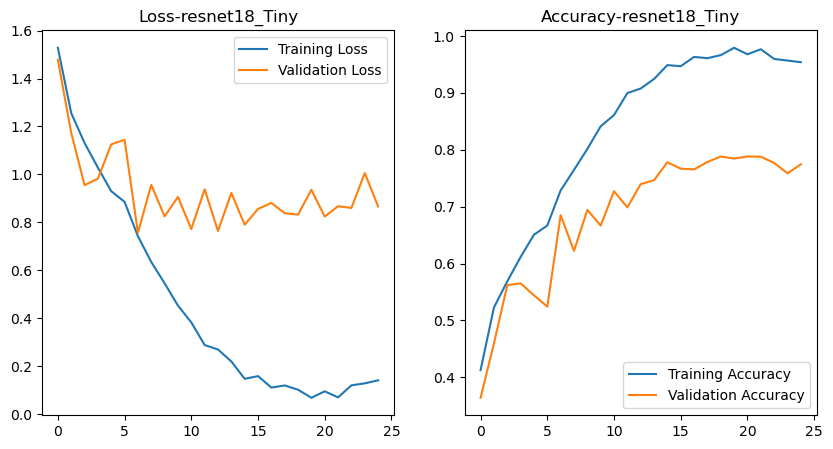

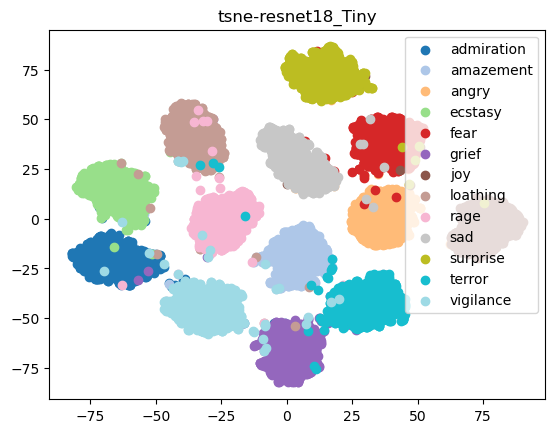

100%|██████████| 24/24 [00:25<00:00,  1.05s/it]


Test Results:
Test Accuracy: 0.7906

              precision    recall  f1-score   support

           0       0.67      0.85      0.75       230
           1       0.72      0.80      0.76       230
           2       0.75      0.77      0.76       230
           3       0.91      0.81      0.86       230
           4       0.85      0.67      0.75       230
           5       0.74      0.76      0.75       230
           6       0.89      0.94      0.92       230
           7       0.84      0.73      0.78       230
           8       0.76      0.77      0.76       230
           9       0.73      0.85      0.79       230
          10       0.90      0.87      0.88       230
          11       0.91      0.73      0.81       230
          12       0.71      0.73      0.72       230

    accuracy                           0.79      2990
   macro avg       0.80      0.79      0.79      2990
weighted avg       0.80      0.79      0.79      2990



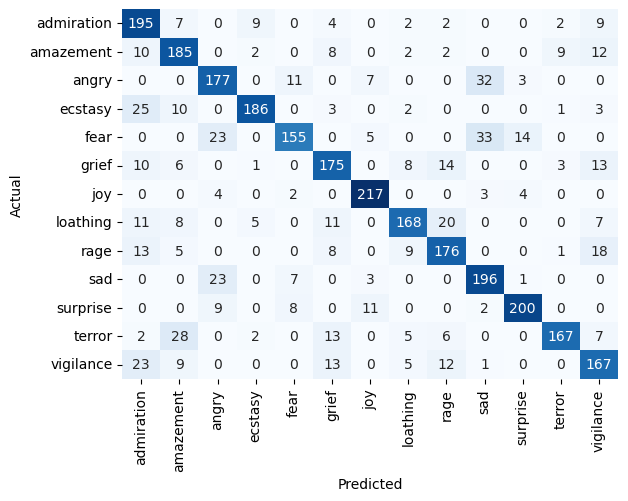

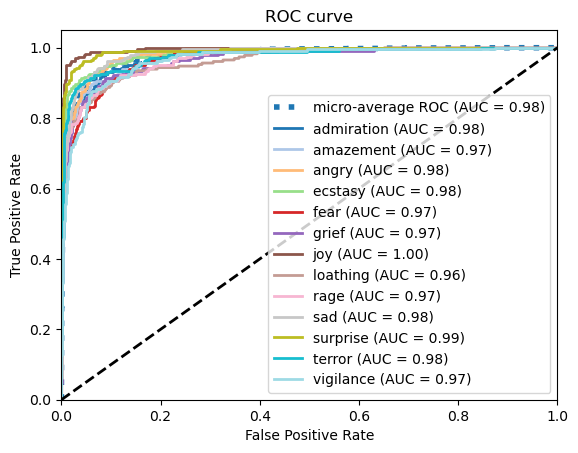

In [7]:
for data in ['fer2013/FER2013','tinydataset/Tiny']:
    datasetName = data.split('/')[1]
    print('--------------------------------------------------------------------------------------------------------')
    print(datasetName)
    print('--------------------------------------------------------------------------------------------------------')
    train_dir = '/kaggle/input/'+data+'/train/'
    val_dir = '/kaggle/input/'+data+'/validation/'
    test_dir ='/kaggle/input/'+data+'/test/'

    train_images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(train_dir) for f in filenames if f.endswith(('.jpg', '.png'))]
    val_images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(val_dir) for f in filenames if f.endswith(('.jpg', '.png'))]
    test_images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(test_dir) for f in filenames if f.endswith(('.jpg', '.png'))]

    print('train_images:',len(train_images))
    print('val_images:',len(val_images))
    print('test_images:',len(test_images))

    train_transforms = transforms.Compose(
        [transforms.ToTensor(),
        transforms.RandomHorizontalFlip(),
        transforms.Resize((224, 224))
        ])

    test_transforms = transforms.Compose(
        [transforms.ToTensor(),
        transforms.Resize((224, 224))
        ])

    device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
    torch.cuda.empty_cache()

    train_data = dataset(train_dir, train_transforms, device)
    train_loader = DataLoader(train_data, batch_size = 128, shuffle = True)

    val_data = dataset(val_dir, train_transforms, device)
    val_loader = DataLoader(val_data, batch_size = 128, shuffle = True)

    test_data = dataset(test_dir, test_transforms, device)
    test_loader = DataLoader(test_data, batch_size = 128, shuffle = False)

    plot_data_loader(train_loader, (4, 4), train_data.class_names)

    for mdl in ['resnet18']:
        print('--------------------------------------------------------------------------------------------------------')
        print(mdl+"_"+datasetName)
        print('--------------------------------------------------------------------------------------------------------')
        if mdl == 'resnet18':
            model = models.resnet18(pretrained=True)
            model.fc = torch.nn.Linear(model.fc.in_features, len(train_data.class_names))
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)

        model.to(device)
        print("Device: {}".format(device))

        flops = 0
        for name, module in model.named_modules():
            if isinstance(module, torch.nn.Conv2d):
                flops += 2 * module.in_channels * module.out_channels * module.kernel_size[0] ** 2 * (224 // module.stride[0]) ** 2
            elif isinstance(module, torch.nn.Linear):
                flops += 2 * module.in_features * module.out_features

        print(f"FLOPS: {flops / 1e9:.3f} billion")


        start = time.time()

        num_epochs = 25
        patience = 7
        best_acc = 0  
        best_model = None

        train_losses = []
        train_accs = []
        val_losses = []
        val_accs = []

        for epoch in range(num_epochs):

            train_loss, train_acc = train_model(model, train_loader, criterion, optimizer, device)
            val_loss, val_acc = val_model(model, val_loader, criterion, device)

            print(f'Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}')

            train_losses.append(train_loss)
            train_accs.append(train_acc)
            val_losses.append(val_loss)
            val_accs.append(val_acc)

            if val_acc > best_acc:
                best_acc = val_acc
                epochs_no_improve = 0  
                best_model = copy.deepcopy(model)
            else:
                epochs_no_improve += 1
                if epochs_no_improve == patience:
                    print(f'Early stopping at epoch {epoch+1}')
                    break
        end = time.time()
        torch.save(best_model.state_dict(), 'TL_'+mdl+'_'+datasetName+'.pth')
        print("Average time per epoch: {:.2f} seconds".format((end - start) / epoch))
        
        train_accs=torch.tensor(train_accs)
        val_accs = torch.tensor(val_accs)  

        fig, axs = plt.subplots(1, 2, figsize=(10, 5))

        axs[0].plot(train_losses, label="Training Loss")
        axs[0].plot(val_losses, label="Validation Loss")
        axs[0].set_title("Loss-"+mdl+'_'+datasetName)
        axs[0].legend()

        val_accs = val_accs.cpu().numpy()  
        axs[1].plot(train_accs, label="Training Accuracy")
        axs[1].plot(val_accs, label="Validation Accuracy")
        axs[1].set_title("Accuracy-"+mdl+'_'+datasetName)
        axs[1].legend()

        plt.show()

        label_names = train_data.class_names
        cmap = colormap.get_cmap('tab20',len(label_names))
        colors = [cmap(i) for i in range(len(label_names))]
        features = []
        labels = []

        with torch.no_grad():
            for images, target in train_loader:
                images = images.to(device) 
                outputs = best_model(images)
                features.append(outputs.view(outputs.size(0), -1).cpu().numpy())
                labels.append(target.cpu().numpy())

        features = np.concatenate(features, axis=0)
        labels = np.concatenate(labels, axis=0)
        tsne = TSNE(n_components=2, random_state=0)
        tsne_features = tsne.fit_transform(features)

        for label_id in range(len(label_names)):
            mask = (labels == label_id).flatten()
            plt.scatter(tsne_features[mask, 0], tsne_features[mask, 1], c=colors[label_id], label=label_names[label_id])
        plt.legend()
        plt.title('tsne-'+mdl+'_'+datasetName)
        plt.show()

        test_model(best_model, test_loader, criterion, device)